--- 1. Setup and Data Loading ---
Successfully loaded data. Feature dimension: 504
Total samples: 19032
Unlabeled samples (originally -1): 14721
Labeled (Tier) samples: 4311
Data has been standardized.

--- 3. UMAP Parameter Testing and Visualization ---

Running UMAP (Combination 1/5): n_neighbors=15, min_dist=0.05


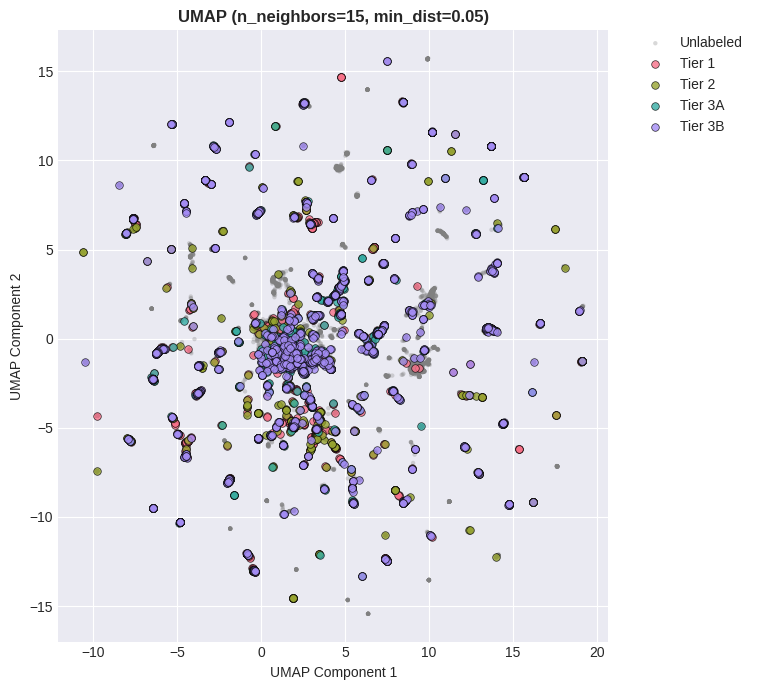


Running UMAP (Combination 2/5): n_neighbors=30, min_dist=0.1


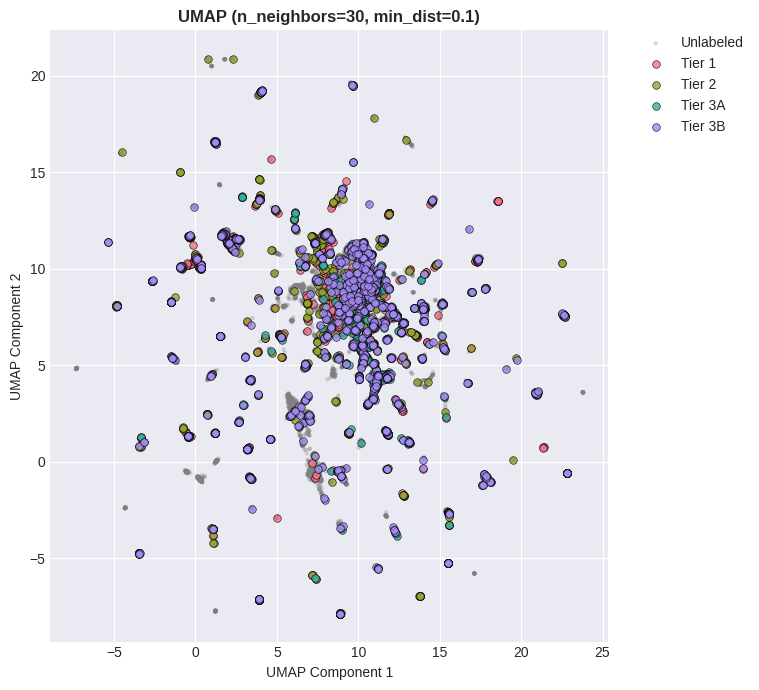


Running UMAP (Combination 3/5): n_neighbors=50, min_dist=0.3


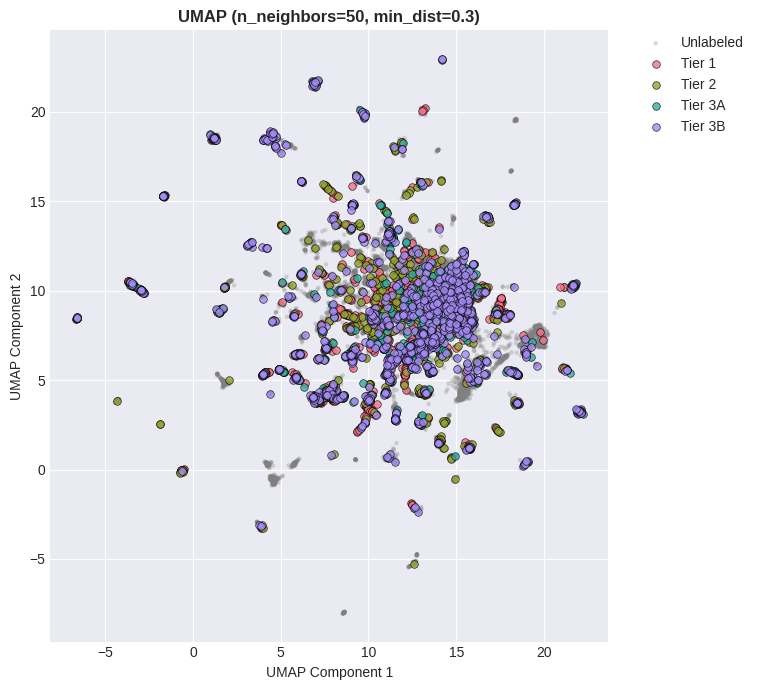


Running UMAP (Combination 4/5): n_neighbors=10, min_dist=0.5


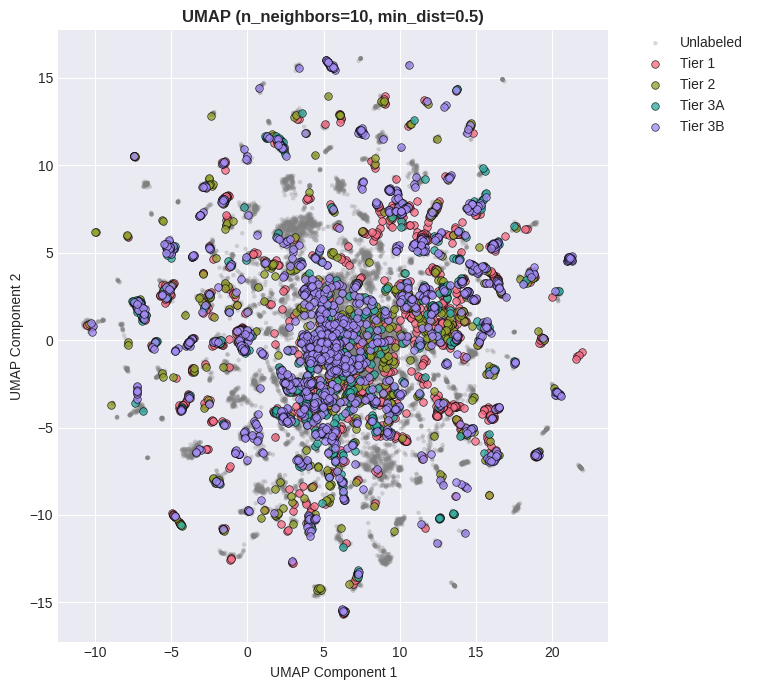


Running UMAP (Combination 5/5): n_neighbors=100, min_dist=0.01


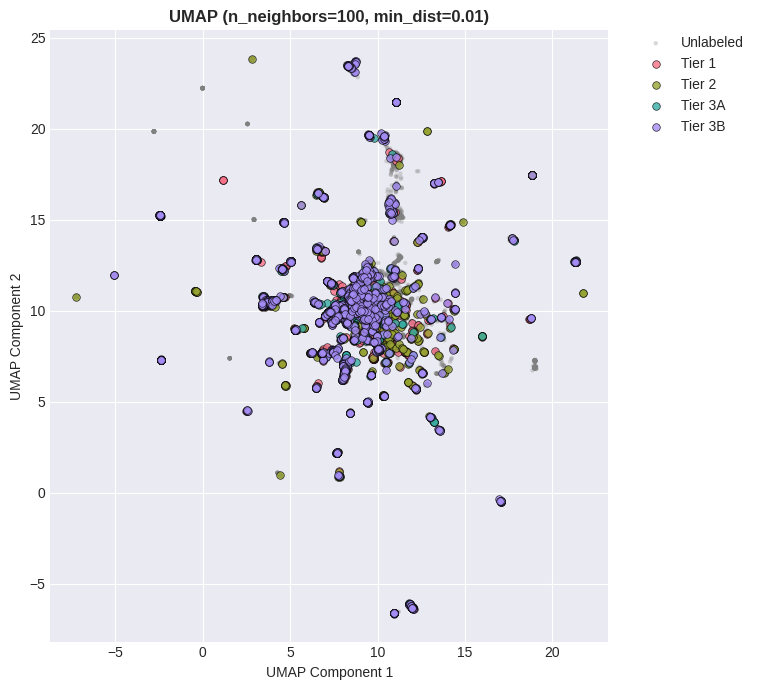


--- UMAP Parameter Testing Complete ---

--- 4. Observation and Analysis Suggestions ---
Please carefully observe the UMAP plots generated above, focusing on these key points:
1. **Separability between Unlabeled and Labeled (Tier 1-3B) data:**
   - Do the gray points (**Unlabeled**) form a distinct, non-overlapping cluster from the colored points (**Labeled**)?
   - If they are heavily mixed, it suggests that distinguishing them based on features alone is difficult, which aligns with your previous nearest neighbor analysis and overall Silhouette Score.
   - If they are well-separated, then your classifier's high PR-AUC in distinguishing 'Druggable' vs. 'Non-druggable' is visually verifiable.
2. **Separability within Labeled Tier categories:**
   - Do the different colored points (**Tier 1, Tier 2, Tier 3A, Tier 3B**) form clear, distinct clusters?
   - Are there clear boundaries between them, or do they heavily interpenetrate and overlap?
   - If they overlap significantly, it aligns 

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import warnings

warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

# --- 1. Setup and Data Loading ---
print("--- 1. Setup and Data Loading ---")

# Set plotting style and color palette
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl") # Use a consistent color scheme for labeled Tier categories

# Define data path
GRAPH_PATH = "/home/zihend1/Genesis/KNOT/data/gene_graph.pt"

# Load data
try:
    data = torch.load(GRAPH_PATH)
    # Handle NaN values in data, replacing them with 0
    if torch.isnan(data.x).any():
        data.x[torch.isnan(data.x)] = 0
    X_all = data.x.cpu().numpy()
    print(f"Successfully loaded data. Feature dimension: {X_all.shape[1]}")
except FileNotFoundError:
    print(f"Error: File not found. Please check the path: {GRAPH_PATH}")
    exit() # Exit if file not found
except Exception as e:
    print(f"An error occurred while loading data: {e}")
    exit()

# Label processing
y_raw = np.array(data.y)
# Map raw labels to numerical values: -1 -> 0 (Unlabeled), Tier 1 -> 1, Tier 2 -> 2, etc.
label_map = {'-1': 0, 'Tier 1': 1, 'Tier 2': 2, 'Tier 3A': 3, 'Tier 3B': 4}
y_all = np.vectorize(label_map.get)(y_raw)

# Define class names for legends and titles
# "Unlabeled" now clearly refers to the -1 original labels.
class_names = ["Unlabeled", "Tier 1", "Tier 2", "Tier 3A", "Tier 3B"]

# Print data overview
print(f"Total samples: {len(X_all)}")
print(f"Unlabeled samples (originally -1): {np.sum(y_all == 0)}")
print(f"Labeled (Tier) samples: {np.sum(y_all > 0)}")

# Standardize data
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)
print("Data has been standardized.")


def plot_umap_embedding(X_embedded, y, title, ax, class_names):
    """
    Plots a 2D UMAP embedding, distinguishing between unlabeled and labeled categories.
    Unlabeled samples are shown in gray, labeled samples use distinct colors.
    """
    
    # Get colors for Tier categories (excluding gray for unlabeled)
    tier_colors = sns.color_palette("husl", len(class_names) - 1) # Get colors for Tier 1-4
    # Define a custom colormap: gray for unlabeled, then Tier colors
    cmap_list = ['#808080'] + list(tier_colors) # #808080 is a medium gray
    custom_cmap = ListedColormap(cmap_list)
    
    # Plot unlabeled samples (y == 0) - gray
    unlabeled_mask = (y == 0)
    if np.sum(unlabeled_mask) > 0:
        ax.scatter(X_embedded[unlabeled_mask, 0], 
                   X_embedded[unlabeled_mask, 1], 
                   c=custom_cmap(0), s=10, alpha=0.3, label=class_names[0], edgecolors='none')
    
    # Plot labeled Tier samples (y > 0) - distinct colors
    for i in range(1, len(class_names)): # Iterate through Tier 1 to Tier 3B (indices 1 to 4)
        tier_mask = (y == i)
        if np.sum(tier_mask) > 0:
            ax.scatter(X_embedded[tier_mask, 0], 
                       X_embedded[tier_mask, 1], 
                       c=custom_cmap(i), s=30, alpha=0.8, 
                       label=class_names[i], edgecolors='black', linewidth=0.5)

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('UMAP Component 1')
    ax.set_ylabel('UMAP Component 2')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # Place legend outside the plot


# --- 3. UMAP Parameter Testing and Visualization ---
print("\n--- 3. UMAP Parameter Testing and Visualization ---")

# Define UMAP parameter combinations to test
# Adjust these parameters as needed to observe different effects
umap_param_combinations = [
    {"n_neighbors": 15, "min_dist": 0.05}, # Emphasizes local structure, allows tighter clusters
    {"n_neighbors": 30, "min_dist": 0.1},  # Default or common parameters, balances local and global
    {"n_neighbors": 50, "min_dist": 0.3},  # Emphasizes global structure, larger distances between clusters
    {"n_neighbors": 10, "min_dist": 0.5},  # Strongly emphasizes local, forces greater separation, may show fragmentation
    {"n_neighbors": 100, "min_dist": 0.01} # Emphasizes very large global structure, but very tight clusters
]

# Generate UMAP plots for each parameter combination
for i, params in enumerate(umap_param_combinations):
    print(f"\nRunning UMAP (Combination {i+1}/{len(umap_param_combinations)}): n_neighbors={params['n_neighbors']}, min_dist={params['min_dist']}")
    
    # Create UMAP instance and perform dimensionality reduction
    umap_reducer = umap.UMAP(
        n_components=2,
        n_neighbors=params['n_neighbors'],
        min_dist=params['min_dist'],
        random_state=42 # Ensure reproducibility
    )
    X_umap = umap_reducer.fit_transform(X_all_scaled)
    
    # Plot UMAP results
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    title = f"UMAP (n_neighbors={params['n_neighbors']}, min_dist={params['min_dist']})"
    plot_umap_embedding(X_umap, y_all, title, ax, class_names)
    
    plt.tight_layout(rect=[0, 0, 0.78, 1]) # Adjust layout to make space for the legend
    plt.show()

print("\n--- UMAP Parameter Testing Complete ---")


# --- 4. Observation and Analysis Suggestions ---
print("\n--- 4. Observation and Analysis Suggestions ---")
print("Please carefully observe the UMAP plots generated above, focusing on these key points:")
print("1. **Separability between Unlabeled and Labeled (Tier 1-3B) data:**")
print("   - Do the gray points (**Unlabeled**) form a distinct, non-overlapping cluster from the colored points (**Labeled**)?")
print("   - If they are heavily mixed, it suggests that distinguishing them based on features alone is difficult, which aligns with your previous nearest neighbor analysis and overall Silhouette Score.")
print("   - If they are well-separated, then your classifier's high PR-AUC in distinguishing 'Druggable' vs. 'Non-druggable' is visually verifiable.")
print("2. **Separability within Labeled Tier categories:**")
print("   - Do the different colored points (**Tier 1, Tier 2, Tier 3A, Tier 3B**) form clear, distinct clusters?")
print("   - Are there clear boundaries between them, or do they heavily interpenetrate and overlap?")
print("   - If they overlap significantly, it aligns with your previous negative Silhouette Score for positive classes. This indicates that classification among these fine-grained categories will be challenging.")
print("3. **Impact of different UMAP parameters:**")
print("   - Try to find the parameter combination that most clearly illustrates the separation of the groups you are interested in.")
print("   - A larger `min_dist` often makes clusters appear more dispersed.")
print("   - Different `n_neighbors` values affect how the algorithm balances local and global structure.")

print("\nThrough visualization, you can better understand the potential structure of your data in high-dimensional space and how your classifier might 'perceive' this data.")

--- 1. Setup and Data Loading ---
Successfully loaded data. Feature dimension: 503

--- 2. Label Processing for Binary Classification ---
Total samples: 19032
Unlabeled samples (Class 0): 14721
Labeled (Tier) samples (Class 1): 4311

--- 3. Data Splitting and Standardization ---
Data split into training/testing sets and standardized.

--- 4. Train a Simple Binary Classifier (Logistic Regression) ---
Logistic Regression model trained successfully.

--- 5. Model Evaluation and Statistics ---

--- Classification Report ---
                precision    recall  f1-score   support

     Unlabeled       0.92      0.97      0.94      2945
Labeled (Tier)       0.86      0.71      0.78       862

      accuracy                           0.91      3807
     macro avg       0.89      0.84      0.86      3807
  weighted avg       0.91      0.91      0.90      3807


--- Confusion Matrix ---
[[2848   97]
 [ 254  608]]


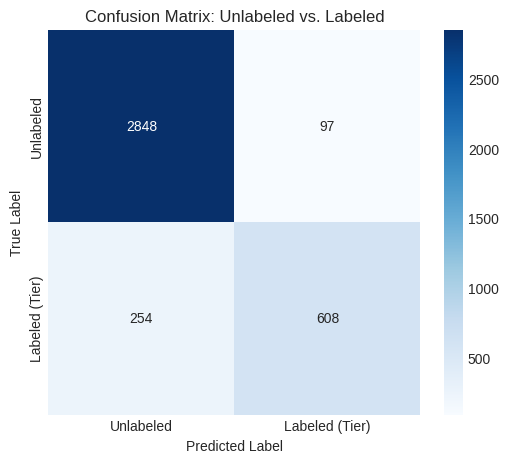


--- ROC Curve and AUC ---
ROC AUC: 0.9379


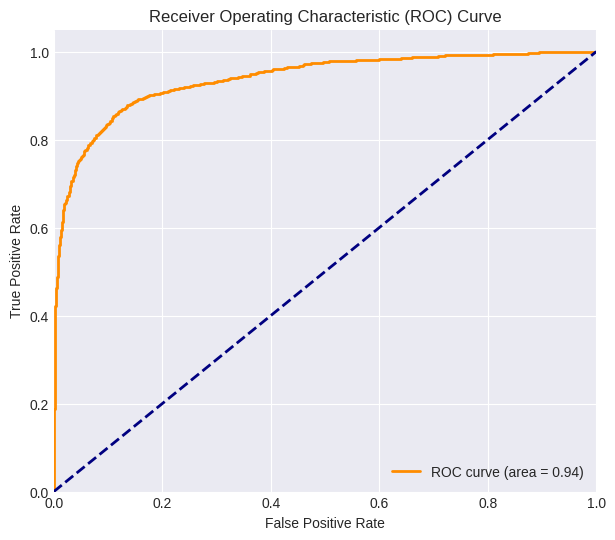


--- Precision-Recall Curve and AP Score ---
Average Precision (AP / PR-AUC): 0.8675


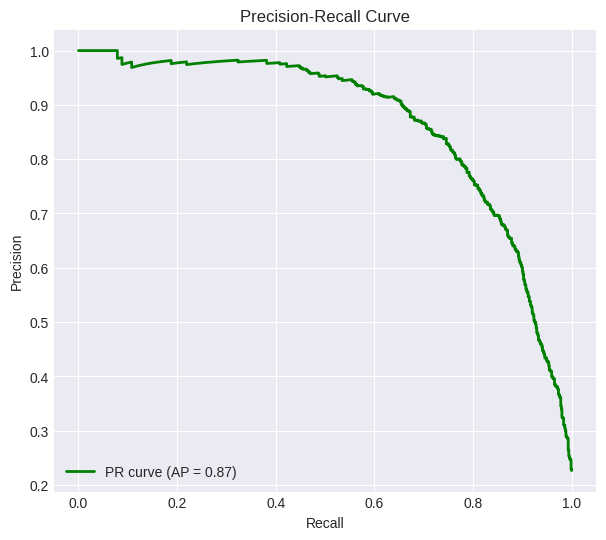


--- 6. Visualize Classification Results on UMAP Projection ---
Generating UMAP embedding for visualization (n_neighbors=30, min_dist=0.1)...


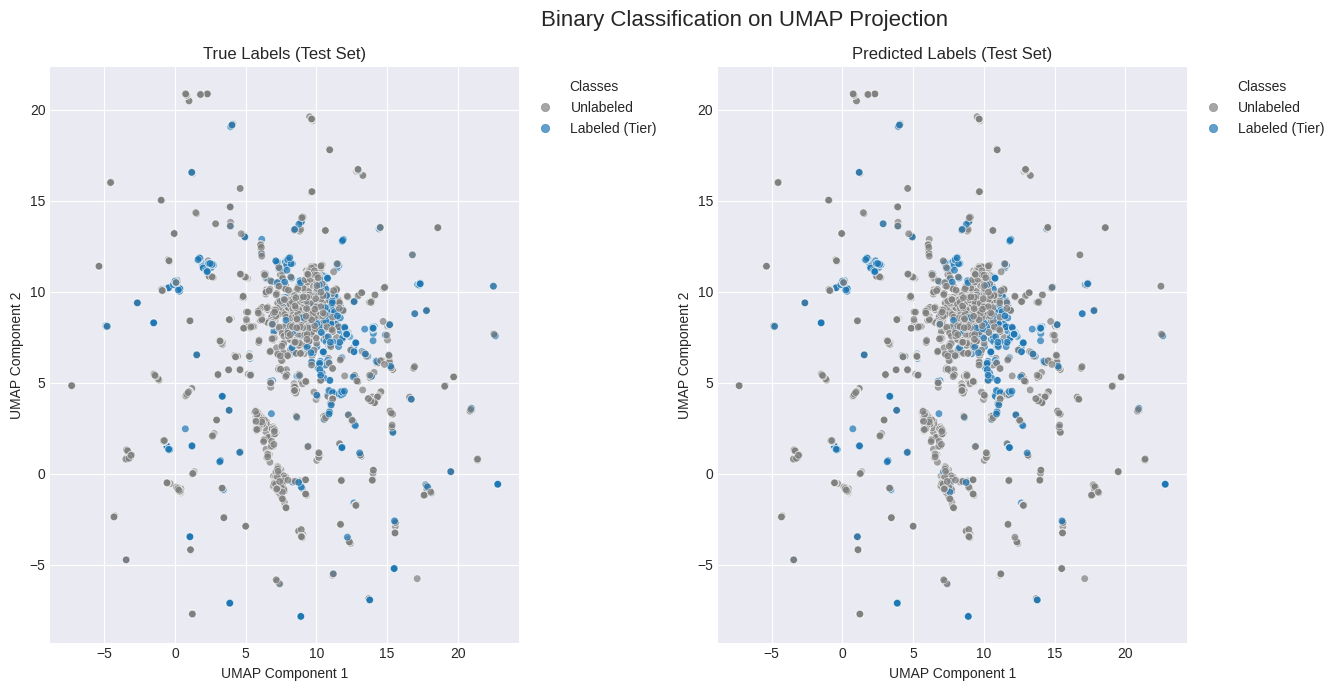


--- Binary Classification Analysis Complete ---


In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from matplotlib.colors import ListedColormap
import warnings

warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

# --- 1. Setup and Data Loading ---
print("--- 1. Setup and Data Loading ---")

# Set plotting style and color palette
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl") 

# Define data path
GRAPH_PATH = "/home/zihend1/Genesis/KNOT/data/gene_graph.pt"

# Load data
try:
    data = torch.load(GRAPH_PATH)
    # Handle NaN values in data, replacing them with 0
    if torch.isnan(data.x).any():
        data.x[torch.isnan(data.x)] = 0
    X_all = data.x.cpu().numpy()
    print(f"Successfully loaded data. Feature dimension: {X_all.shape[1]}")
except FileNotFoundError:
    print(f"Error: File not found. Please check the path: {GRAPH_PATH}")
    exit() 
except Exception as e:
    print(f"An error occurred while loading data: {e}")
    exit()

# --- 2. Label Processing for Binary Classification ---
# Original labels: -1, Tier 1, Tier 2, Tier 3A, Tier 3B
# New binary labels: 0 for Unlabeled (-1), 1 for Labeled (all Tiers)
print("\n--- 2. Label Processing for Binary Classification ---")

y_raw = np.array(data.y)

# Create a binary target variable: 0 for Unlabeled, 1 for any Tier
# np.where(condition, value_if_true, value_if_false)
y_binary = np.where(y_raw == '-1', 0, 1) 

# Define class names for the binary task
binary_class_names = ["Unlabeled", "Labeled (Tier)"]

print(f"Total samples: {len(X_all)}")
print(f"Unlabeled samples (Class 0): {np.sum(y_binary == 0)}")
print(f"Labeled (Tier) samples (Class 1): {np.sum(y_binary == 1)}")

# --- 3. Data Splitting and Standardization ---
print("\n--- 3. Data Splitting and Standardization ---")

# Include indices in the initial split to correctly get test_indices later
indices = np.arange(len(X_all))
X_train, X_test, y_train_binary, y_test_binary, train_indices, test_indices = train_test_split(
    X_all, y_binary, indices, test_size=0.2, stratify=y_binary, random_state=42
)

# Standardize features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Data split into training/testing sets and standardized.")

# --- 4. Train a Simple Binary Classifier (Logistic Regression) ---
print("\n--- 4. Train a Simple Binary Classifier (Logistic Regression) ---")

# Initialize Logistic Regression model
# max_iter is increased for convergence on potentially complex datasets
# solver='liblinear' is good for small datasets and L1/L2 regularization
# random_state for reproducibility
clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

# Train the model
clf.fit(X_train_scaled, y_train_binary)
print("Logistic Regression model trained successfully.")

# Make predictions on the test set
y_pred_binary = clf.predict(X_test_scaled)
# Get probability estimates for the positive class (Labeled)
y_prob_binary = clf.predict_proba(X_test_scaled)[:, 1] 

# --- 5. Model Evaluation and Statistics ---
print("\n--- 5. Model Evaluation and Statistics ---")

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test_binary, y_pred_binary, target_names=binary_class_names))

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test_binary, y_pred_binary)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=binary_class_names, yticklabels=binary_class_names)
plt.title('Confusion Matrix: Unlabeled vs. Labeled')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve and AUC
print("\n--- ROC Curve and AUC ---")
fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob_binary)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall Curve and Average Precision (AP / PR-AUC)
print("\n--- Precision-Recall Curve and AP Score ---")
precision, recall, _ = precision_recall_curve(y_test_binary, y_prob_binary)
ap_score = average_precision_score(y_test_binary, y_prob_binary)
print(f"Average Precision (AP / PR-AUC): {ap_score:.4f}")

plt.figure(figsize=(7, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# --- 6. Visualize Classification Results on UMAP Projection ---
print("\n--- 6. Visualize Classification Results on UMAP Projection ---")

# First, generate UMAP embedding for visualization
# Using a common UMAP parameter set for this visualization
print("Generating UMAP embedding for visualization (n_neighbors=30, min_dist=0.1)...")
umap_reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
X_umap_all = umap_reducer.fit_transform(X_all_scaled)

# Use the test_indices obtained from the train_test_split to get the UMAP coordinates for the test set
X_test_umap = X_umap_all[test_indices]


# Define custom colormaps for binary classes
# Unlabeled (0) = Grey, Labeled (1) = Blue
binary_cmap_list = ['#808080', '#1f77b4'] # Gray for Unlabeled, default blue for Labeled
custom_binary_cmap = ListedColormap(binary_cmap_list)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Binary Classification on UMAP Projection', fontsize=16)

# Plot True Labels on UMAP
ax = axes[0]
scatter = ax.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=y_test_binary, 
                     cmap=custom_binary_cmap, s=30, alpha=0.7, edgecolors='w', linewidth=0.5)
ax.set_title('True Labels (Test Set)')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
legend_elements_true = scatter.legend_elements() # Get elements for legend
ax.legend(handles=legend_elements_true[0], labels=binary_class_names, 
                    title="Classes", loc="upper left", bbox_to_anchor=(1,1))


# Plot Predicted Labels on UMAP
ax = axes[1]
scatter = ax.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=y_pred_binary, 
                     cmap=custom_binary_cmap, s=30, alpha=0.7, edgecolors='w', linewidth=0.5)
ax.set_title('Predicted Labels (Test Set)')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
legend_elements_pred = scatter.legend_elements() # Get elements for legend
ax.legend(handles=legend_elements_pred[0], labels=binary_class_names, 
                    title="Classes", loc="upper left", bbox_to_anchor=(1,1))

plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for legends
plt.show()

print("\n--- Binary Classification Analysis Complete ---")

Data Overview:
Total samples: 19032
Features: 503
Positive (labeled): 4311 (22.7%)
Unlabeled: 14721 (77.3%)

Positive class distribution:
   Tier 1: 1399 (32.5%)
   Tier 2: 649 (15.1%)
   Tier 3A: 839 (19.5%)
   Tier 3B: 1424 (33.0%)

PERFORMING DIMENSIONALITY REDUCTION

1. PCA Analysis...
   Explained variance (first 10 PCs): [0.08426841 0.03521901 0.02885283 0.02451879 0.01870806 0.01663961
 0.01564142 0.0139115  0.01290653 0.01246284]
   Cumulative variance (50 PCs): 0.521

2. UMAP embedding...

CREATING VISUALIZATIONS


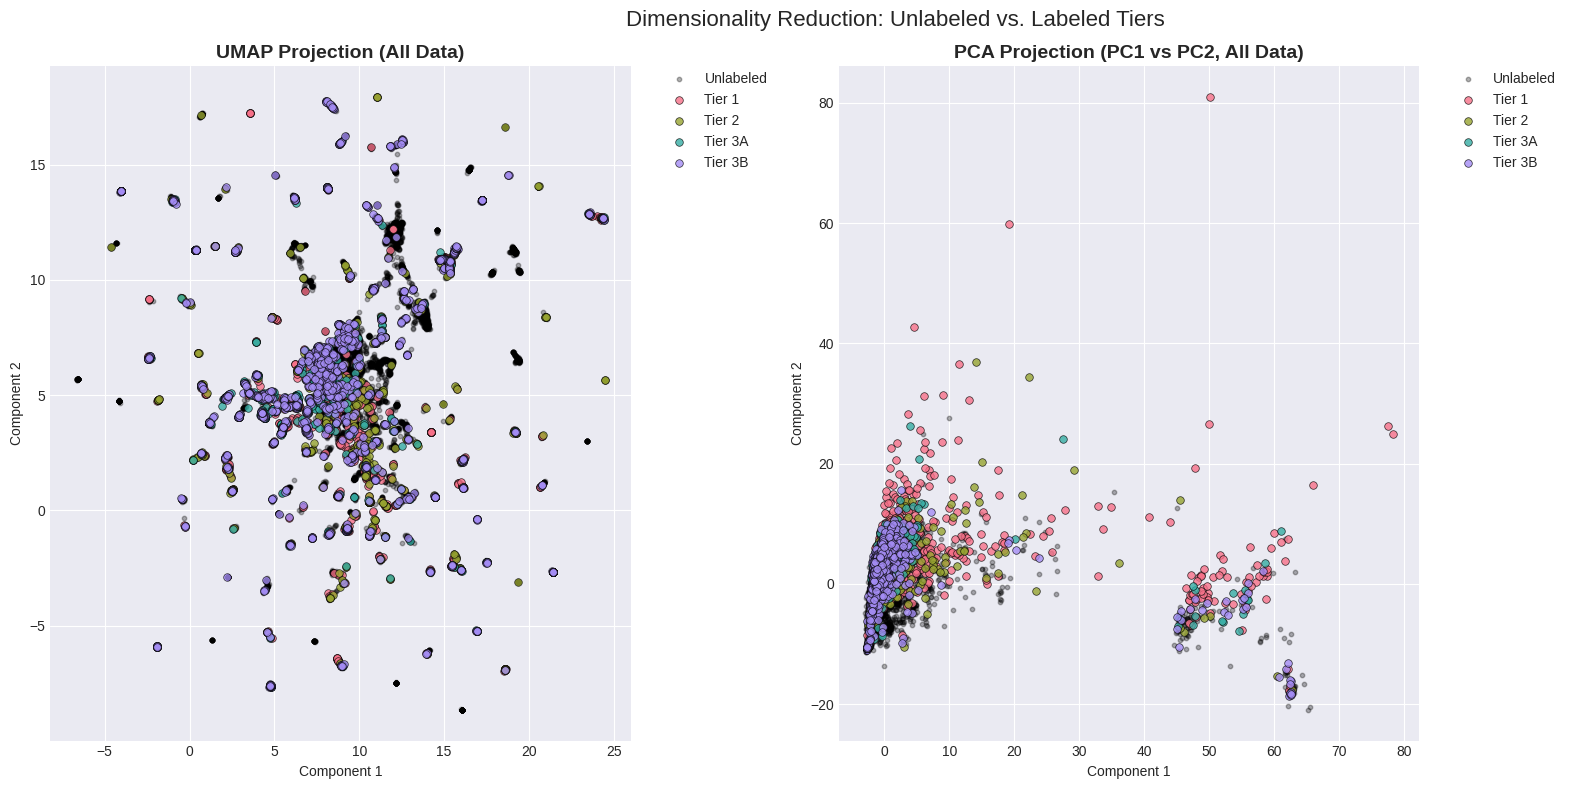

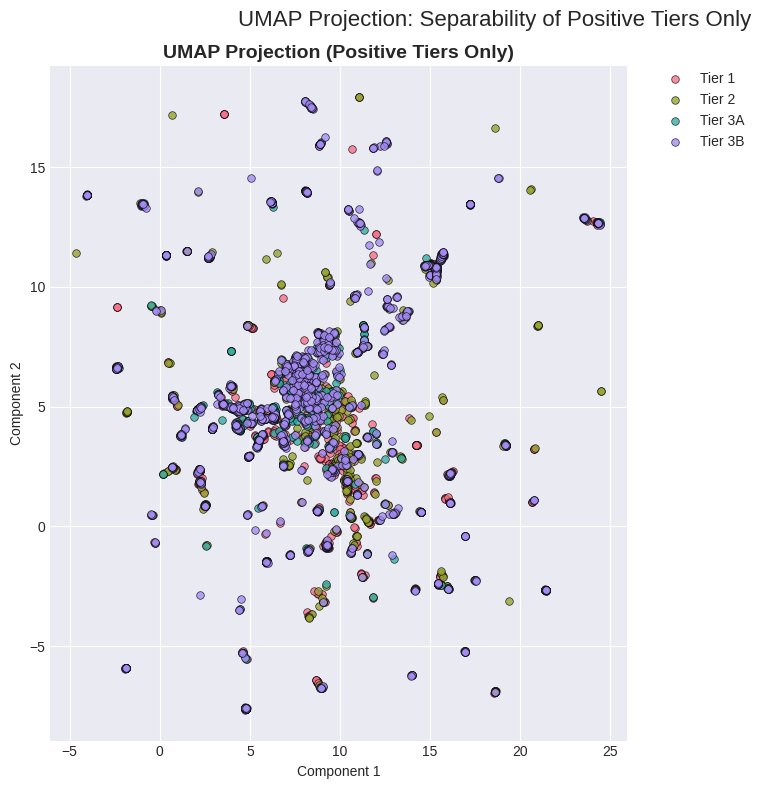

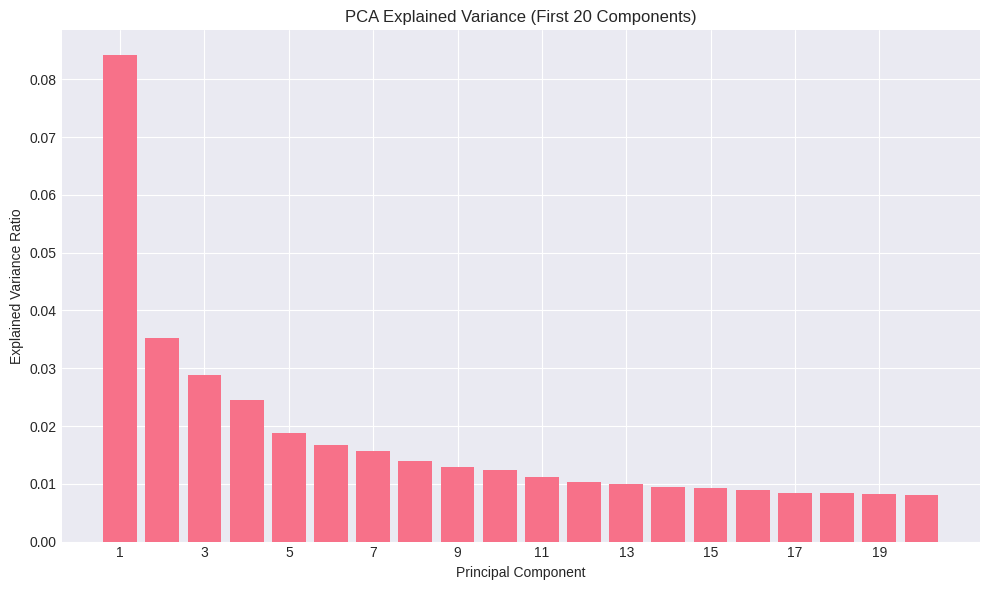


STATISTICAL ANALYSIS OF SEPARABILITY

1. Nearest Neighbor Analysis:
   Testing if unlabeled samples are similar to labeled...
   Average distance from unlabeled to positive: 16.446
   Average distance within positive samples: 16.882
   Ratio: 0.974

2. Feature Distribution Analysis:
   Comparing feature distributions between labeled and unlabeled...
   Features with significantly different distributions: 13/20 (65.0%)


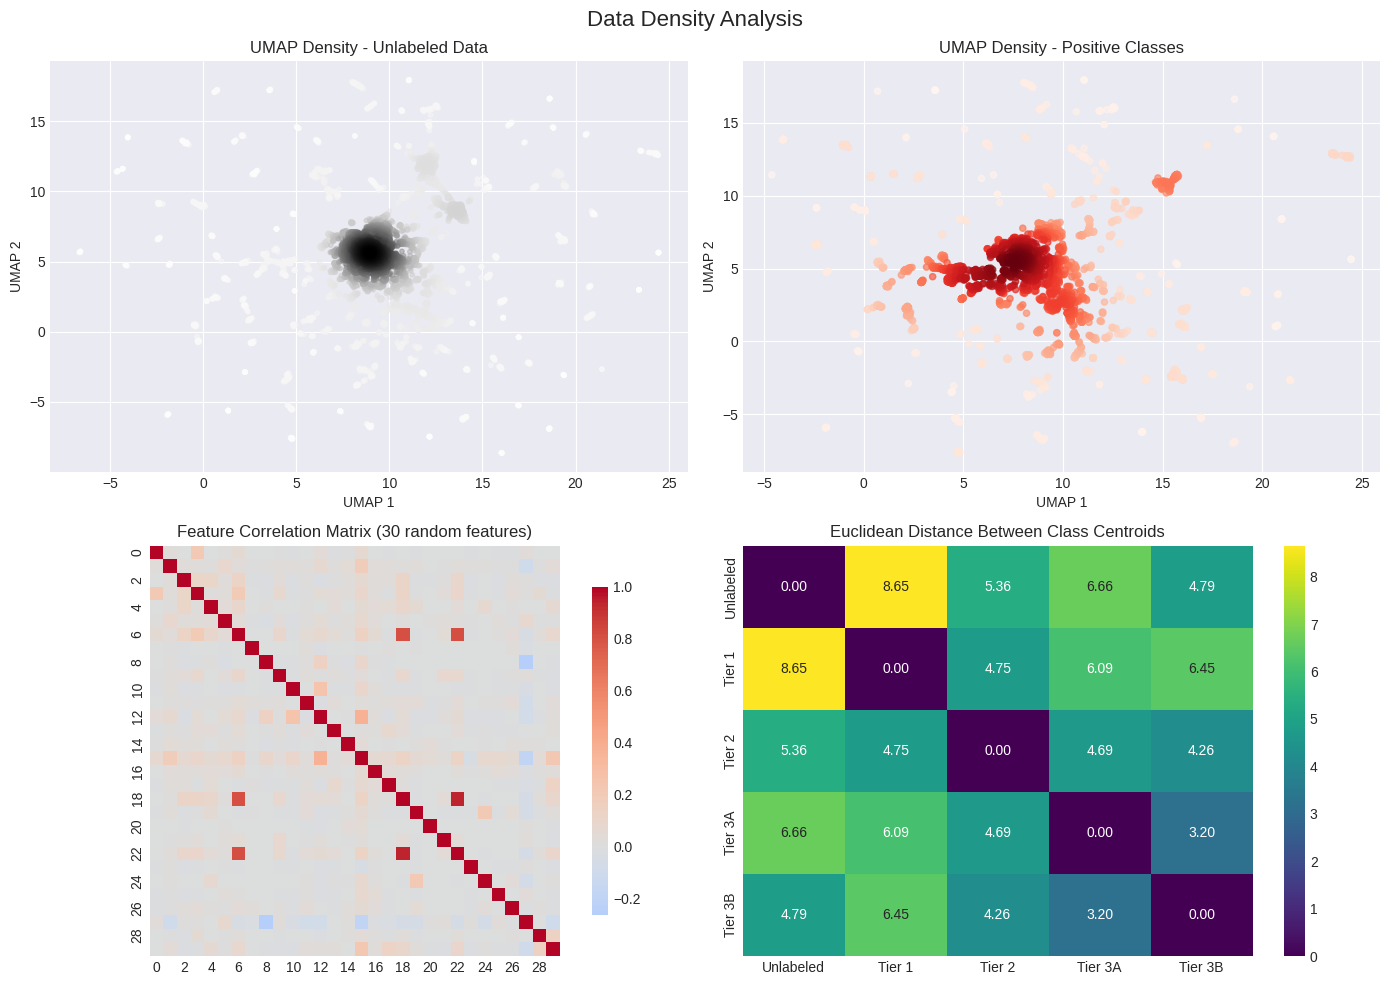


MULTICLASS ANALYSIS

Random Forest:
   CV F1 Score: 0.460 (+/- 0.024)

KNN:
   CV F1 Score: 0.423 (+/- 0.019)


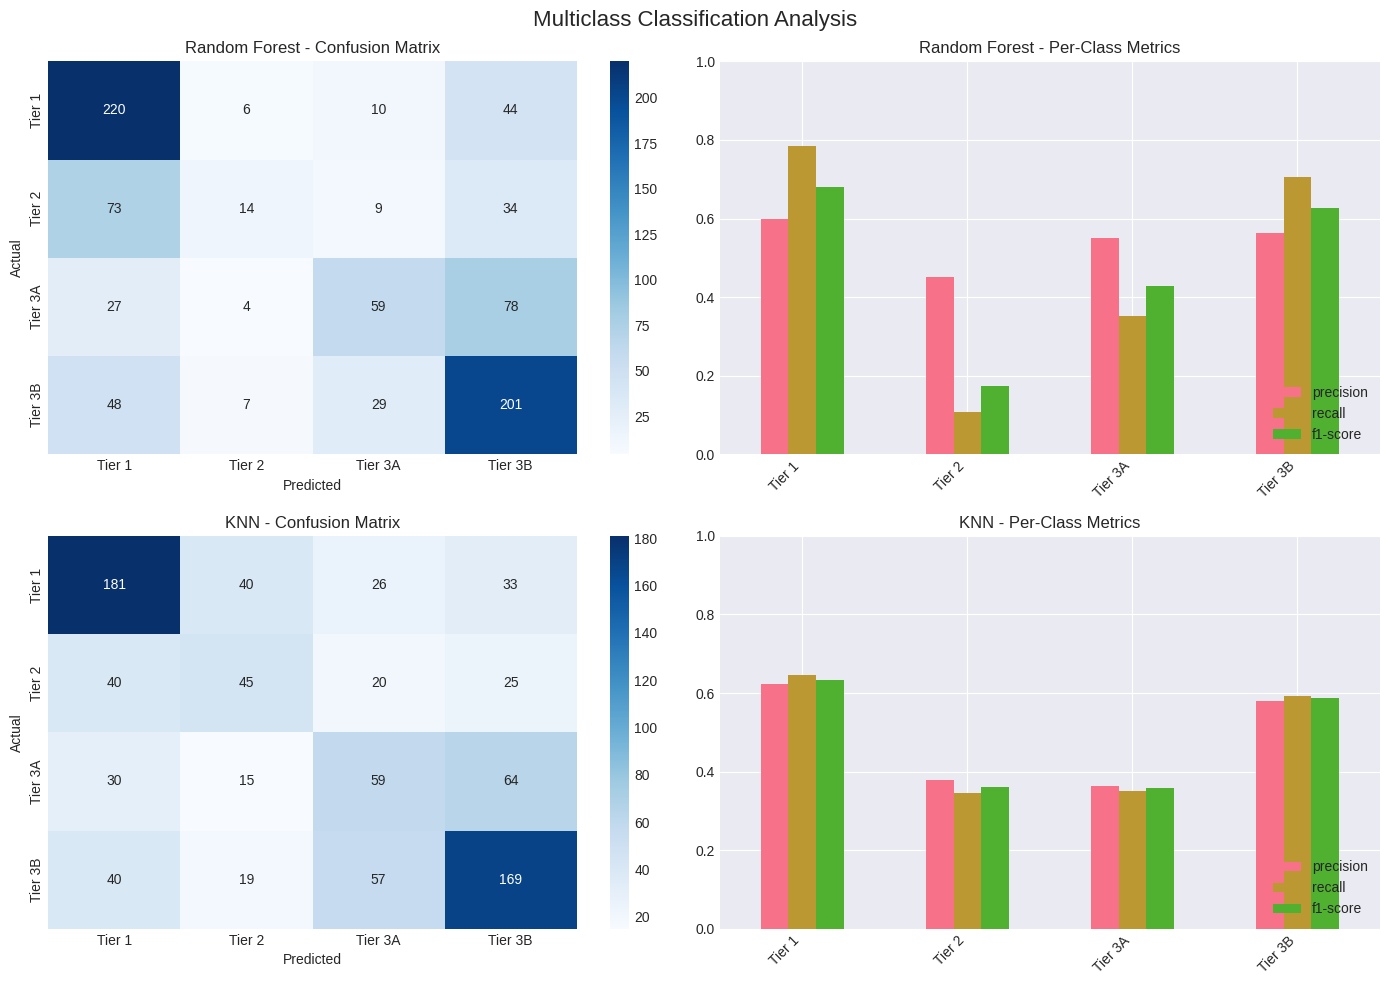


CLASS OVERLAP ANALYSIS

Silhouette Score (positive classes): -0.069
Silhouette Score (all data): 0.052

Pairwise Class Separability (using RF probability):
Random Forest Classifier not trained or no positive samples available.

SEPARABILITY ASSESSMENT

Separability Score: 1/4

Detailed Assessment:
   ✗ Unlabeled samples are relatively close to positive samples
   ✓ A significant portion of features show different distributions
   ✗ Positive classes (Tiers) show significant overlap
   ✗ Unlabeled data significantly overlaps with positive classes

RECOMMENDATIONS
✗ Data shows poor separability - **PU learning may be challenging**
   - Consider **active learning** to selectively label more ambiguous samples
   - Leverage **domain knowledge** to guide further labeling or feature engineering
   - Prioritize semi-supervised learning methods that can better handle overlap

Next Steps:
1. **Visually inspect UMAP and PCA plots** to confirm perceived cluster separation.
2. **Analyze confusion m

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
from sklearn.metrics import confusion_matrix, classification_report, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from scipy import stats
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ---------------------- Load data ----------------------
GRAPH_PATH = "/home/zihend1/Genesis/KNOT/data/gene_graph.pt"
data = torch.load(GRAPH_PATH)
if torch.isnan(data.x).any():
    data.x[torch.isnan(data.x)] = 0
X_all = data.x.cpu().numpy()

# Process labels
y_raw = np.array(data.y)
label_map = {'-1': 0, 'Tier 1': 1, 'Tier 2': 2, 'Tier 3A': 3, 'Tier 3B': 4}
y_all = np.vectorize(label_map.get)(y_raw)
class_names = ["Unlabeled", "Tier 1", "Tier 2", "Tier 3A", "Tier 3B"] # Updated class_names

# Separate data
positive_mask = y_all > 0
unlabeled_mask = y_all == 0

X_positive = X_all[positive_mask]
y_positive = y_all[positive_mask]
X_unlabeled = X_all[unlabeled_mask]

print("Data Overview:")
print(f"Total samples: {len(X_all)}")
print(f"Features: {X_all.shape[1]}")
print(f"Positive (labeled): {len(X_positive)} ({len(X_positive)/len(X_all)*100:.1f}%)")
print(f"Unlabeled: {len(X_unlabeled)} ({len(X_unlabeled)/len(X_all)*100:.1f}%)")
print("\nPositive class distribution:")
for i in range(1, 5):
    count = np.sum(y_positive == i)
    print(f"   {class_names[i]}: {count} ({count/len(X_positive)*100:.1f}%)")

# ---------------------- Dimensionality Reduction ----------------------

# Standardize data
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)
X_positive_scaled = X_all_scaled[positive_mask]
X_unlabeled_scaled = X_all_scaled[unlabeled_mask]

print("\n" + "="*60)
print("PERFORMING DIMENSIONALITY REDUCTION")
print("="*60)

# 1. PCA Analysis
print("\n1. PCA Analysis...")
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_all_scaled)
print(f"   Explained variance (first 10 PCs): {pca.explained_variance_ratio_[:10]}")
print(f"   Cumulative variance (50 PCs): {np.sum(pca.explained_variance_ratio_):.3f}")

# 2. UMAP
print("\n2. UMAP embedding...")
umap_reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
X_umap = umap_reducer.fit_transform(X_all_scaled)
# Also fit UMAP on just positive data if needed for tier-specific plotting clarity
umap_reducer_positive = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
X_umap_positive = umap_reducer_positive.fit_transform(X_positive_scaled)


# ---------------------- Visualization Functions ----------------------

def plot_embedding(X_embedded, y, title, ax, show_legend=True, mode='all'):
    """
    Plot 2D embedding with color coding.
    mode: 'all' for unlabeled vs. labeled tiers, 'tiers_only' for just tiers
    """
    
    # Custom colormap
    if mode == 'all':
        tier_colors = sns.color_palette("husl", 4) # Get 4 distinct colors for Tiers
        cmap_list = ["#000000"] + [tier_colors[i] for i in range(4)] # Grey + Tier colors
        cmap = ListedColormap(cmap_list)
        
        # Plot unlabeled first (background)
        unlabeled_indices = y == 0
        if np.sum(unlabeled_indices) > 0:
            ax.scatter(X_embedded[unlabeled_indices, 0], 
                       X_embedded[unlabeled_indices, 1], 
                       c=cmap(0), s=10, alpha=0.3, label=class_names[0]) 
        
        # Plot each positive class (Tier 1, Tier 2, Tier 3A, Tier 3B)
        for i in range(1, 5):
            indices = y == i
            if np.sum(indices) > 0:
                ax.scatter(X_embedded[indices, 0], 
                           X_embedded[indices, 1], 
                           c=cmap(i), s=30, alpha=0.8, 
                           label=class_names[i], edgecolors='black', linewidth=0.5)
    
    elif mode == 'tiers_only':
        # Create a mapping for y values (1,2,3,4) to palette indices (0,1,2,3)
        # Ensure that only positive classes are present in y
        unique_tiers = np.unique(y[y > 0]) # Get actual tiers present in data
        tier_palette = sns.color_palette("husl", len(unique_tiers))
        
        for i, tier_val in enumerate(unique_tiers):
            indices = y == tier_val
            if np.sum(indices) > 0:
                ax.scatter(X_embedded[indices, 0], 
                           X_embedded[indices, 1], 
                           c=[tier_palette[i]], s=30, alpha=0.8, 
                           label=class_names[tier_val], edgecolors='black', linewidth=0.5)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    
    if show_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# ---------------------- Main Visualization ----------------------

print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

# Figure 1: UMAP and PCA plots showing Unlabeled vs. Labeled
fig1, axes1 = plt.subplots(1, 2, figsize=(18, 8))
fig1.suptitle('Dimensionality Reduction: Unlabeled vs. Labeled Tiers', fontsize=16)

# UMAP - Unlabeled vs. Labeled
plot_embedding(X_umap, y_all, 'UMAP Projection (All Data)', axes1[0], mode='all')

# PCA (first 2 components) - Unlabeled vs. Labeled
plot_embedding(X_pca[:, :2], y_all, 'PCA Projection (PC1 vs PC2, All Data)', axes1[1], mode='all')

plt.tight_layout(rect=[0, 0, 0.88, 1]) # Adjust layout to make space for legend
plt.show()


# Figure 2: UMAP plot focusing on Tier separation (only labeled data)
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 8))
fig2.suptitle('UMAP Projection: Separability of Positive Tiers Only', fontsize=16)

# UMAP - Tiers Only (using X_umap_positive and y_positive)
plot_embedding(X_umap[positive_mask], y_positive, 'UMAP Projection (Positive Tiers Only)', ax2, mode='tiers_only')

plt.tight_layout(rect=[0, 0, 0.78, 1]) # Adjust layout for single plot legend
plt.show()


# Figure 3: PCA Variance Plot (kept separate for clarity)
fig_pca_var, ax_pca_var = plt.subplots(1, 1, figsize=(10, 6))
ax_pca_var.bar(range(1, 21), pca.explained_variance_ratio_[:20])
ax_pca_var.set_xlabel('Principal Component')
ax_pca_var.set_ylabel('Explained Variance Ratio')
ax_pca_var.set_title('PCA Explained Variance (First 20 Components)')
ax_pca_var.set_xticks(range(1, 21, 2))
plt.tight_layout()
plt.show()


# ---------------------- Statistical Analysis ----------------------

print("\n" + "="*60)
print("STATISTICAL ANALYSIS OF SEPARABILITY")
print("="*60)

# 1. Nearest Neighbor Analysis
print("\n1. Nearest Neighbor Analysis:")
print("   Testing if unlabeled samples are similar to labeled...")

# For each unlabeled point, find nearest labeled neighbors
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_positive_scaled, y_positive)

# Get distances and indices of nearest neighbors
# Ensure there are enough unlabeled samples to avoid errors
n_unlabeled_samples_to_sample = min(1000, len(X_unlabeled_scaled))
if n_unlabeled_samples_to_sample > 0:
    distances, indices = knn.kneighbors(X_unlabeled_scaled[:n_unlabeled_samples_to_sample])
    avg_distance_to_positive = np.mean(distances)
else:
    avg_distance_to_positive = float('inf') # Set to infinity if no unlabeled samples

# Compare with distances between positive samples
# Ensure there are enough positive samples to avoid errors
n_positive_samples_to_sample = min(1000, len(X_positive_scaled))
if n_positive_samples_to_sample > 0:
    pos_knn = KNeighborsClassifier(n_neighbors=10)
    pos_knn.fit(X_positive_scaled, y_positive)
    pos_distances, _ = pos_knn.kneighbors(X_positive_scaled[:n_positive_samples_to_sample])
    avg_distance_within_positive = np.mean(pos_distances)
else:
    avg_distance_within_positive = 0 # No distance if no positive samples or only one

print(f"   Average distance from unlabeled to positive: {avg_distance_to_positive:.3f}")
print(f"   Average distance within positive samples: {avg_distance_within_positive:.3f}")
if avg_distance_within_positive > 0:
    print(f"   Ratio: {avg_distance_to_positive/avg_distance_within_positive:.3f}")
else:
    print(f"   Ratio: N/A (Cannot calculate due to zero distance within positive samples)")


# 2. Feature Distribution Analysis
print("\n2. Feature Distribution Analysis:")
print("   Comparing feature distributions between labeled and unlabeled...")

# Sample features to analyze
n_features_to_test = min(20, X_all.shape[1])
if n_features_to_test > 0:
    feature_indices = np.random.choice(X_all.shape[1], n_features_to_test, replace=False)

    significantly_different = 0
    for feat_idx in feature_indices:
        # Kolmogorov-Smirnov test
        # Only perform if both positive and unlabeled sets are non-empty for the feature
        if len(X_positive[:, feat_idx]) > 0 and len(X_unlabeled[:, feat_idx]) > 0:
            ks_stat, p_value = stats.ks_2samp(
                X_positive[:, feat_idx], 
                X_unlabeled[:, feat_idx]
            )
            if p_value < 0.05:
                significantly_different += 1
        else:
            # If one group is empty, they can't be statistically compared for difference
            pass 
    print(f"   Features with significantly different distributions: "
          f"{significantly_different}/{n_features_to_test} "
          f"({significantly_different/n_features_to_test*100:.1f}%)")
else:
    print("   Not enough features to perform distribution analysis.")


# ---------------------- Density Analysis ----------------------

# Figure 4: Density plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Data Density Analysis', fontsize=16)

# UMAP density for unlabeled
ax = axes[0, 0]
from scipy.stats import gaussian_kde

unlabeled_umap = X_umap[y_all == 0]
if len(unlabeled_umap) > 10: # Need at least 2 points for kde, usually more for meaningful plot
    xy = np.vstack([unlabeled_umap[:, 0], unlabeled_umap[:, 1]])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = unlabeled_umap[idx, 0], unlabeled_umap[idx, 1], z[idx]
    scatter = ax.scatter(x, y, c=z, s=10, cmap='Greys', alpha=0.5)
    
ax.set_title('UMAP Density - Unlabeled Data')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

# Plot density for positive classes combined
ax = axes[0, 1]
positive_umap = X_umap[y_all > 0]
if len(positive_umap) > 10: # Need at least 2 points for kde
    xy = np.vstack([positive_umap[:, 0], positive_umap[:, 1]])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = positive_umap[idx, 0], positive_umap[idx, 1], z[idx]
    scatter = ax.scatter(x, y, c=z, s=20, cmap='Reds', alpha=0.7)
ax.set_title('UMAP Density - Positive Classes')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

# Feature correlation heatmap
ax = axes[1, 0]
# Sample features for visualization
if X_all.shape[1] > 0:
    sample_features = np.random.choice(X_all.shape[1], min(30, X_all.shape[1]), replace=False)
    corr_matrix = np.corrcoef(X_all_scaled[:, sample_features].T)
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
                square=True, ax=ax, cbar_kws={"shrink": 0.8})
    ax.set_title(f'Feature Correlation Matrix ({len(sample_features)} random features)')
else:
    ax.set_title('No features to display correlation')
    ax.text(0.5, 0.5, 'No features available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


# Class overlap analysis
ax = axes[1, 1]
# Calculate pairwise distances between class centroids
centroids = []
labels = []
# Ensure there are samples in each group before computing centroid
if np.sum(y_all == 0) > 0:
    centroids.append(np.mean(X_unlabeled_scaled, axis=0))
    labels.append(class_names[0]) # Use 'Unlabeled'
for i in range(1, 5): # Iterate through positive tiers
    if np.sum(y_positive == i) > 0:
        centroids.append(np.mean(X_positive_scaled[y_positive == i], axis=0))
        labels.append(class_names[i])

if len(centroids) > 1:
    centroids = np.array(centroids)
    n_classes_centroids = len(centroids)
    distances = np.zeros((n_classes_centroids, n_classes_centroids))

    for i in range(n_classes_centroids):
        for j in range(n_classes_centroids):
            distances[i, j] = np.linalg.norm(centroids[i] - centroids[j])

    sns.heatmap(distances, annot=True, fmt='.2f', cmap='viridis',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title('Euclidean Distance Between Class Centroids')
else:
    ax.set_title('Not enough classes to compute centroid distances')
    ax.text(0.5, 0.5, 'Requires at least 2 class centroids', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

# ---------------------- Multiclass Visualization ----------------------

print("\n" + "="*60)
print("MULTICLASS ANALYSIS")
print("="*60)

# Train a classifier to see how well we can separate the positive classes
from sklearn.model_selection import train_test_split, cross_val_score

if len(X_positive_scaled) > 0 and len(np.unique(y_positive)) > 1:
    X_train, X_test, y_train, y_test = train_test_split(
        X_positive_scaled, y_positive, test_size=0.2, stratify=y_positive, random_state=42
    )

    # Train multiple classifiers
    classifiers = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5),
    }

    fig, axes = plt.subplots(len(classifiers), 2, figsize=(14, 5 * len(classifiers))) # Dynamic figure size
    fig.suptitle('Multiclass Classification Analysis', fontsize=16)

    # Flatten axes if only one row for consistent indexing
    if len(classifiers) == 1:
        axes = np.expand_dims(axes, axis=0) # Make it 2D if it's 1D

    for idx, (name, clf) in enumerate(classifiers.items()):
        print(f"\n{name}:")
        
        # Cross-validation
        cv_scores = cross_val_score(clf, X_positive_scaled, y_positive, cv=5, scoring='f1_macro')
        print(f"   CV F1 Score: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")
        
        # Train and predict
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Confusion matrix
        ax_cm = axes[idx, 0]
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[class_names[i] for i in range(1, 5)], # Use class_names for tiers
                    yticklabels=[class_names[i] for i in range(1, 5)], # Use class_names for tiers
                    ax=ax_cm)
        ax_cm.set_title(f'{name} - Confusion Matrix')
        ax_cm.set_xlabel('Predicted')
        ax_cm.set_ylabel('Actual')
        
        # Classification report
        report = classification_report(y_test, y_pred, 
                                       target_names=[class_names[i] for i in range(1, 5)],
                                       output_dict=True)
        
        # Plot per-class metrics
        ax_metrics = axes[idx, 1]
        metrics_df = pd.DataFrame(report).T.iloc[:-3]  # Exclude avg rows
        metrics_df[['precision', 'recall', 'f1-score']].plot(kind='bar', ax=ax_metrics)
        ax_metrics.set_title(f'{name} - Per-Class Metrics')
        ax_metrics.set_ylim(0, 1)
        ax_metrics.legend(loc='lower right')
        ax_metrics.set_xticklabels(ax_metrics.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()
else:
    print("Not enough positive labeled samples or classes to perform multiclass classification analysis.")


# ---------------------- Overlap Analysis ----------------------

print("\n" + "="*60)
print("CLASS OVERLAP ANALYSIS")
print("="*60)

# Calculate silhouette score
# For positive classes only
if len(np.unique(y_positive)) > 1 and len(X_positive_scaled) >= 2:
    positive_silhouette = silhouette_score(X_positive_scaled, y_positive)
    print(f"\nSilhouette Score (positive classes): {positive_silhouette:.3f}")
else:
    positive_silhouette = 0 # Default if cannot compute
    print("\nCannot compute Silhouette Score for positive classes (requires at least 2 unique labels and 2 samples).")

# Including unlabeled as a separate class
if len(np.unique(y_all)) > 1 and len(X_all_scaled) >= 2:
    all_silhouette = silhouette_score(X_all_scaled, y_all)
    print(f"Silhouette Score (all data): {all_silhouette:.3f}")
else:
    all_silhouette = 0 # Default if cannot compute
    print("Cannot compute Silhouette Score for all data (requires at least 2 unique labels and 2 samples).")


# Pairwise class overlap using classifier confidence
print("\nPairwise Class Separability (using RF probability):")
if 'rf' in locals() and len(X_positive_scaled) > 0: # Check if rf classifier was trained successfully
    for i in range(1, 5): # Iterate through tiers
        # Get samples from this class
        class_samples_indices = np.where(y_positive == i)[0]
        if len(class_samples_indices) > 0:
            class_samples = X_positive_scaled[class_samples_indices]
            
            # Predict probabilities - ensure classifier is fit
            if hasattr(rf, 'classes_') and (i in rf.classes_): # Check if the class was present in training data
                probs = rf.predict_proba(class_samples)
                
                # Average probability for correct class
                # Map true label 'i' (1-4) to classifier's internal index (0-3)
                try:
                    correct_class_idx_in_clf = np.where(rf.classes_ == i)[0][0]
                    correct_class_prob = np.mean(probs[:, correct_class_idx_in_clf])
                    
                    print(f"\n   {class_names[i]}:")
                    print(f"     Average confidence for correct class: {correct_class_prob:.3f}")
                    
                    # Top confusions
                    avg_probs = np.mean(probs, axis=0)
                    for j_idx, prob_val in enumerate(avg_probs):
                        predicted_tier_label = rf.classes_[j_idx] # Get the actual tier label from classifier's classes_
                        if predicted_tier_label != i:
                            print(f"     Average probability for {class_names[predicted_tier_label]}: {prob_val:.3f}")
                except IndexError:
                    print(f"     Class {class_names[i]} not found in classifier's training data.")
            else:
                print(f"   Classifier not trained with class {class_names[i]} or not fit.")
        else:
            print(f"   No samples found for {class_names[i]} to analyze pairwise separability.")
else:
    print("Random Forest Classifier not trained or no positive samples available.")


# ---------------------- Recommendations ----------------------

print("\n" + "="*60)
print("SEPARABILITY ASSESSMENT")
print("="*60)

# Calculate separability metrics
separability_score = 0
reasons = []

# 1. Distance ratio
if avg_distance_within_positive > 0 and avg_distance_to_positive / avg_distance_within_positive > 1.2:
    separability_score += 1
    reasons.append("✓ Unlabeled samples are notably distant from positive samples")
else:
    reasons.append("✗ Unlabeled samples are relatively close to positive samples")

# 2. Feature distributions
if 'significantly_different' in locals() and 'n_features_to_test' in locals() and n_features_to_test > 0:
    if significantly_different / n_features_to_test > 0.3:
        separability_score += 1
        reasons.append("✓ A significant portion of features show different distributions")
    else:
        reasons.append("✗ Feature distributions are largely similar")
else:
    reasons.append("N/A Feature distribution analysis skipped due to insufficient data.")

# 3. Silhouette scores
if positive_silhouette > 0.3:
    separability_score += 1
    reasons.append("✓ Positive classes (Tiers) are reasonably well-separated")
else:
    reasons.append("✗ Positive classes (Tiers) show significant overlap")

if all_silhouette > 0.2:
    separability_score += 1
    reasons.append("✓ Unlabeled data forms a somewhat distinct cluster")
else:
    reasons.append("✗ Unlabeled data significantly overlaps with positive classes")

print(f"\nSeparability Score: {separability_score}/4")
print("\nDetailed Assessment:")
for reason in reasons:
    print(f"   {reason}")

print("\n" + "="*60)
print("RECOMMENDATIONS")
print("="*60)

if separability_score >= 3:
    print("✓ Data shows good separability - **PU learning is appropriate**")
    print("   - Use ensemble methods for robust predictions")
    print("   - Consider a conservative threshold for identifying reliable negatives")
elif separability_score >= 2:
    print("⚠ Data shows moderate separability - **PU learning may work, but with caution**")
    print("   - Use very conservative approaches (e.g., strong negative selection)")
    print("   - Validate predictions carefully with domain expertise")
    print("   - Explore semi-supervised learning alternatives (e.g., self-training with strong initial classifier)")
else:
    print("✗ Data shows poor separability - **PU learning may be challenging**")
    print("   - Consider **active learning** to selectively label more ambiguous samples")
    print("   - Leverage **domain knowledge** to guide further labeling or feature engineering")
    print("   - Prioritize semi-supervised learning methods that can better handle overlap")

print("\nNext Steps:")
print("1. **Visually inspect UMAP and PCA plots** to confirm perceived cluster separation.")
print("2. **Analyze confusion matrices** closely to identify which specific tiers are most frequently misclassified or overlap.")
print("3. **Incorporate domain expertise** to validate the observed clusters and understand biological implications of overlap.")
print("4. If some tiers are highly similar, consider a **hierarchical classification approach** (e.g., first classify into broad categories, then refine into tiers).")

Original data shape: (19032, 504)

PU Learning Data Distribution:
Positive samples: 4311 (22.7%)
Unlabeled samples: 14721 (77.3%)
Positive class distribution:
  Tier 1: 1399
  Tier 2: 649
  Tier 3A: 839
  Tier 3B: 1424

TESTING IMPROVED PU LEARNING METHODS
Identifying reliable negatives using isolation_forest...
isolation_forest: 57 samples (0.4%)
Identifying reliable negatives using distance_based...
distance_based: 2209 samples (15.0%)
Identifying reliable negatives using clustering...
clustering: 1473 samples (10.0%)
Identifying reliable negatives using ensemble...
Identifying reliable negatives using isolation_forest...
Identifying reliable negatives using distance_based...
Identifying reliable negatives using clustering...
ensemble: 1023 samples (6.9%)

Testing improved PU methods...
Applying improved spy technique with 15.0% spy samples...
Improved spy technique: 0 reliable negatives, threshold: 0.195
Applying adaptive two-step PU learning...
Identifying reliable negatives using 

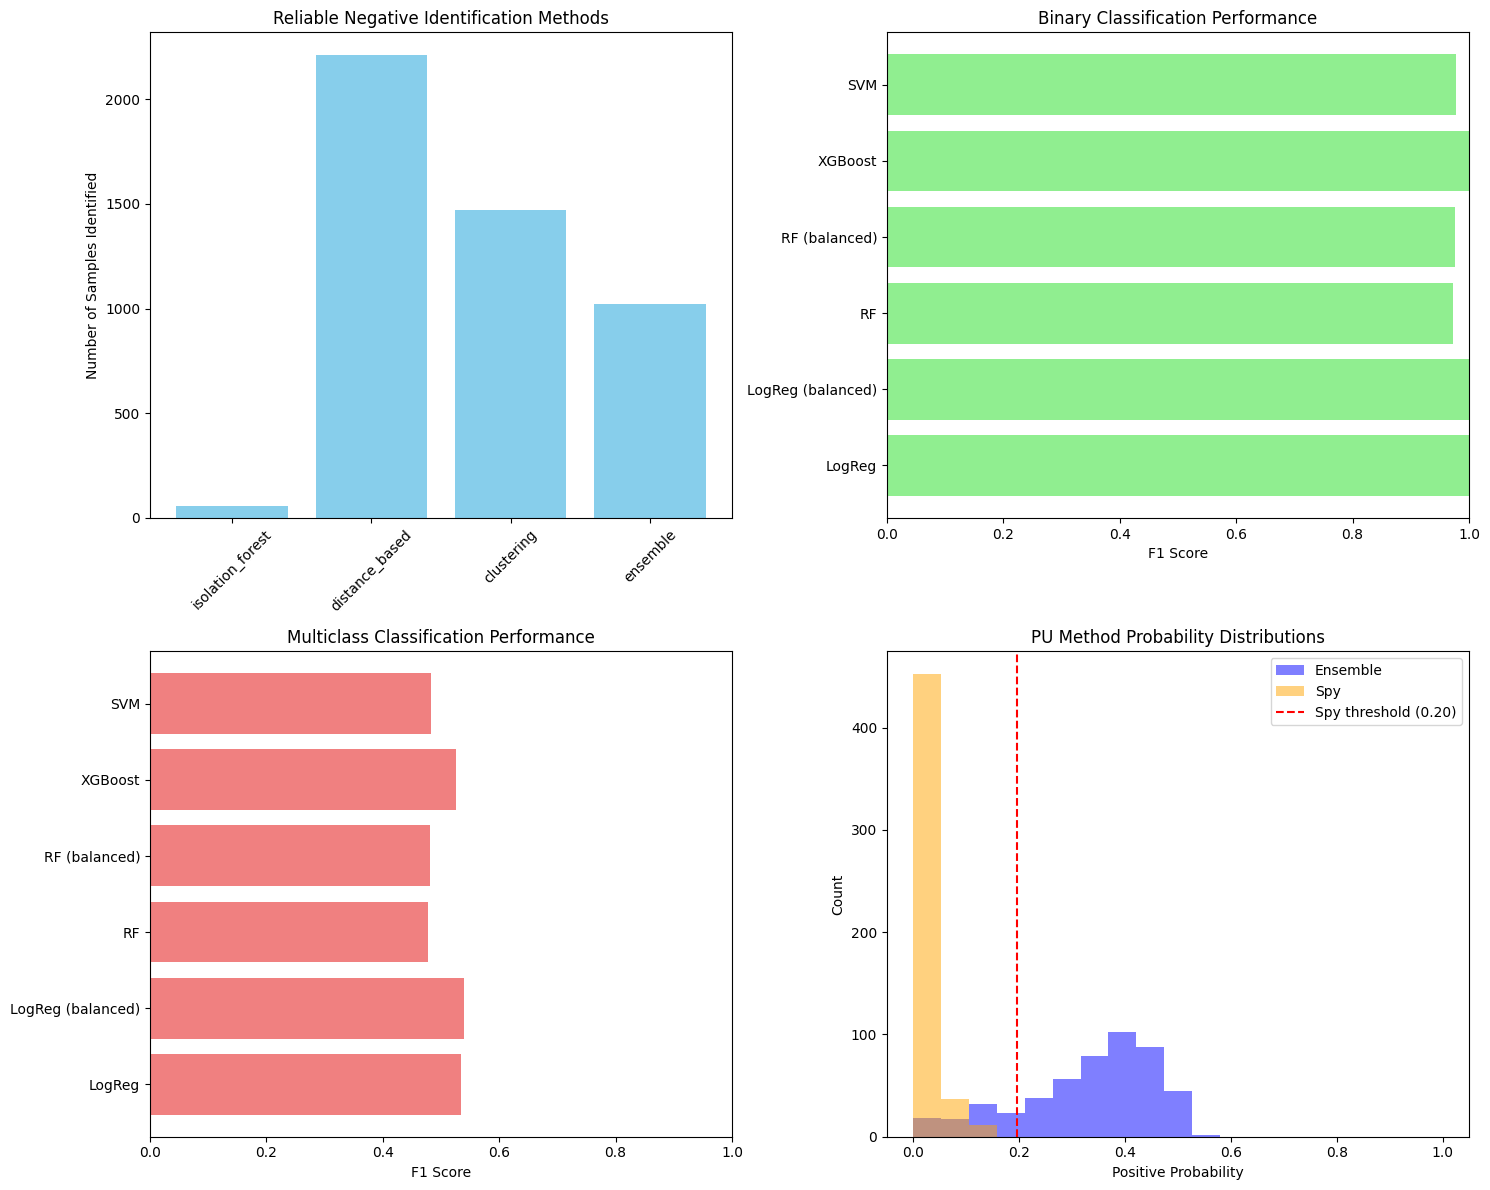


IMPROVED PU LEARNING EVALUATION SUMMARY

Data Summary:
- Total samples: 19032
- Positive (labeled) samples: 4311
- Unlabeled samples: 14721

Reliable Negative Identification:
- isolation_forest: 57 samples (0.4%)
- distance_based: 2209 samples (15.0%)
- clustering: 1473 samples (10.0%)
- ensemble: 1023 samples (6.9%)

Best Models:
- Binary Classification: LogReg (F1: 1.000)
- Multiclass Classification: LogReg (balanced) (F1: 0.539)

PU Method Performance:
- Ensemble classifier: 135/500 positive predictions
- Spy technique: 0/500 positive predictions

Key Improvements Made:
1. Fixed multiclass label issues (0-3 instead of 1-4)
2. Improved reliable negative identification with multiple methods
3. Better spy technique with adaptive thresholding
4. Ensemble-based PU learning for robustness
5. Balanced dataset creation to avoid extreme class imbalance
6. Added distance-based method for reliable negative identification
7. Improved PU bagging with varied contamination rates

ANALYSIS COMPLET

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_score, recall_score, roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import SVC, OneClassSVM
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from xgboost import XGBClassifier
import pandas as pd
import warnings
from collections import Counter
from scipy import stats
warnings.filterwarnings("ignore")

# ----------------------------- SETUP -----------------------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# PU Learning Configuration
PU_LEARNING_METHODS = {
    'two_step': True,      # Two-step PU learning
    'biased_svm': True,    # Biased SVM for PU learning  
    'pu_bagging': True,    # PU Bagging
    'spy_technique': True, # Spy technique
    'roc_analysis': True   # ROC analysis for reliable negatives
}

UNLABELED_SAMPLING_STRATEGIES = {
    'random': 0.3,         # Random sampling ratio
    'reliable_negative': True,  # Use reliable negative identification
    'clustering': True,    # Use clustering-based sampling
    'ensemble': True       # Use ensemble-based sampling
}

# ---------------------- Load data from graph ---------------------
GRAPH_PATH = "/home/zihend1/Genesis/KNOT/data/gene_graph.pt"
data = torch.load(GRAPH_PATH)
if torch.isnan(data.x).any():
    data.x[torch.isnan(data.x)] = 0
X_all = data.x.cpu().numpy()

print(f"Original data shape: {X_all.shape}")

# ------------------------ PU Learning Data Preparation ------------------------
y_raw = np.array(data.y)
label_map = {'-1': 0, 'Tier 1': 1, 'Tier 2': 2, 'Tier 3A': 3, 'Tier 3B': 4}
y_original = np.vectorize(label_map.get)(y_raw)
class_names = ["Unknown", "Tier 1", "Tier 2", "Tier 3A", "Tier 3B"]

# Separate positive (labeled) and unlabeled data
positive_mask = y_original > 0
unlabeled_mask = y_original == 0

X_positive = X_all[positive_mask]
y_positive = y_original[positive_mask]
X_unlabeled = X_all[unlabeled_mask]

# Adjust labels for multiclass (should be 0-3, not 1-4)
y_positive_adjusted = y_positive - 1  # Now 0-3 for multiclass

print(f"\nPU Learning Data Distribution:")
print(f"Positive samples: {len(X_positive)} ({len(X_positive)/len(X_all)*100:.1f}%)")
print(f"Unlabeled samples: {len(X_unlabeled)} ({len(X_unlabeled)/len(X_all)*100:.1f}%)")
print(f"Positive class distribution:")
pos_counts = Counter(y_positive)
for i in range(1, 5):
    if i in pos_counts:
        print(f"  {class_names[i]}: {pos_counts[i]}")

# ---------------------- Improved PU Learning Techniques ----------------------

class ImprovedPULearningTechniques:
    def __init__(self, X_positive, y_positive, X_unlabeled, random_state=42):
        self.X_positive = X_positive
        self.y_positive = y_positive
        self.X_unlabeled = X_unlabeled
        self.random_state = random_state
        
    def identify_reliable_negatives(self, method='isolation_forest', contamination=0.1):
        """Identify reliable negative samples from unlabeled data"""
        print(f"Identifying reliable negatives using {method}...")
        
        if method == 'isolation_forest':
            # Use Isolation Forest with auto contamination
            clf = IsolationForest(contamination='auto', random_state=self.random_state)
            clf.fit(self.X_positive)
            predictions = clf.predict(self.X_unlabeled)
            reliable_neg_mask = predictions == -1
            
        elif method == 'one_class_svm':
            # Use One-Class SVM with adaptive nu
            nu = min(0.5, max(0.01, contamination))  # Ensure nu is in valid range
            clf = OneClassSVM(nu=nu, kernel='rbf', gamma='scale')
            clf.fit(self.X_positive)
            predictions = clf.predict(self.X_unlabeled)
            reliable_neg_mask = predictions == -1
            
        elif method == 'distance_based':
            # Distance-based approach
            from sklearn.neighbors import NearestNeighbors
            n_neighbors = min(10, len(self.X_positive) // 10)
            nbrs = NearestNeighbors(n_neighbors=n_neighbors)
            nbrs.fit(self.X_positive)
            
            distances, _ = nbrs.kneighbors(self.X_unlabeled)
            avg_distances = np.mean(distances, axis=1)
            threshold = np.percentile(avg_distances, (1 - contamination) * 100)
            reliable_neg_mask = avg_distances >= threshold
            
        elif method == 'clustering':
            # Improved clustering approach
            n_clusters = min(10, len(self.X_positive) // 50)
            if n_clusters > 1:
                kmeans = KMeans(n_clusters=n_clusters, random_state=self.random_state)
                kmeans.fit(self.X_positive)
                
                # Calculate distances to all cluster centers
                distances = kmeans.transform(self.X_unlabeled)
                min_distances = np.min(distances, axis=1)
                
                # Use adaptive threshold
                threshold = np.percentile(min_distances, 90)  # Top 10% furthest
                reliable_neg_mask = min_distances >= threshold
            else:
                # Fallback to distance-based
                return self.identify_reliable_negatives('distance_based', contamination)
                
        elif method == 'ensemble':
            # Improved ensemble with voting
            methods = ['isolation_forest', 'distance_based', 'clustering']
            votes = np.zeros(len(self.X_unlabeled))
            
            for m in methods:
                try:
                    mask = self.identify_reliable_negatives(method=m, contamination=contamination)
                    votes += mask.astype(int)
                except Exception as e:
                    print(f"    Warning: {m} failed - {e}")
                    continue
            
            # Require majority vote (at least 2 out of 3)
            reliable_neg_mask = votes >= 2
        
        else:
            raise ValueError(f"Unknown method: {method}")
        
        return reliable_neg_mask
    
    def improved_spy_technique(self, spy_ratio=0.15, confidence_level=0.85):
        """Improved spy technique with better threshold selection"""
        print(f"Applying improved spy technique with {spy_ratio*100:.1f}% spy samples...")
        
        # Select spy samples stratified by positive classes
        n_spy_per_class = max(1, int(len(self.X_positive) * spy_ratio / len(np.unique(self.y_positive))))
        spy_indices = []
        
        for class_label in np.unique(self.y_positive):
            class_indices = np.where(self.y_positive == class_label)[0]
            n_spy_class = min(n_spy_per_class, len(class_indices) // 2)
            spy_indices.extend(np.random.choice(class_indices, n_spy_class, replace=False))
        
        spy_indices = np.array(spy_indices)
        
        # Create training data
        mask = np.ones(len(self.X_positive), dtype=bool)
        mask[spy_indices] = False
        X_train_pos = self.X_positive[mask]
        y_train_pos = np.ones(len(X_train_pos))
        
        # Add spy samples to unlabeled data
        X_spy = self.X_positive[spy_indices]
        X_train_unlabeled = np.vstack([self.X_unlabeled, X_spy])
        y_train_unlabeled = np.zeros(len(X_train_unlabeled))
        
        # Train classifier
        X_train = np.vstack([X_train_pos, X_train_unlabeled])
        y_train = np.hstack([y_train_pos, y_train_unlabeled])
        
        classifier = RandomForestClassifier(n_estimators=200, random_state=self.random_state)
        classifier.fit(X_train, y_train)
        
        # Get probabilities
        probs = classifier.predict_proba(X_train_unlabeled)[:, 1]
        
        # Find threshold using spy samples
        spy_probs = probs[-len(spy_indices):]
        
        # Use confidence interval for threshold
        threshold = np.percentile(spy_probs, (1 - confidence_level) * 100)
        
        # Identify reliable negatives (those with probability below threshold)
        reliable_neg_mask = probs[:-len(spy_indices)] < threshold
        
        # Additional filtering: remove samples that are too close to positives
        if np.sum(reliable_neg_mask) > len(self.X_positive):
            # Keep only the most confident negatives
            neg_probs = probs[:-len(spy_indices)][reliable_neg_mask]
            n_keep = int(len(self.X_positive) * 0.5)  # Balance ratio
            if len(neg_probs) > n_keep:
                threshold_idx = np.argsort(neg_probs)[n_keep]
                new_threshold = neg_probs[threshold_idx]
                reliable_neg_mask = probs[:-len(spy_indices)] < new_threshold
        
        return reliable_neg_mask, threshold, classifier
    
    def adaptive_two_step_pu_learning(self):
        """Adaptive two-step PU learning with better negative selection"""
        print("Applying adaptive two-step PU learning...")
        
        # Step 1: Try multiple methods to identify reliable negatives
        methods = ['ensemble', 'distance_based', 'isolation_forest']
        all_negatives = []
        
        for method in methods:
            try:
                mask = self.identify_reliable_negatives(method=method, contamination=0.15)
                if np.sum(mask) > 0:
                    all_negatives.append(self.X_unlabeled[mask])
            except:
                continue
        
        if not all_negatives:
            print("No reliable negatives found, using conservative random sampling...")
            n_sample = min(len(self.X_unlabeled) // 10, len(self.X_positive) // 2)
            sample_indices = np.random.choice(len(self.X_unlabeled), n_sample, replace=False)
            X_reliable_neg = self.X_unlabeled[sample_indices]
        else:
            # Combine and deduplicate
            X_reliable_neg = np.vstack(all_negatives)
            # Remove duplicates (approximately)
            from sklearn.cluster import DBSCAN
            clustering = DBSCAN(eps=0.1, min_samples=1)
            labels = clustering.fit_predict(X_reliable_neg)
            unique_labels = np.unique(labels)
            X_reliable_neg = np.array([X_reliable_neg[labels == l][0] for l in unique_labels])
        
        # Ensure reasonable balance
        if len(X_reliable_neg) > len(self.X_positive):
            indices = np.random.choice(len(X_reliable_neg), len(self.X_positive), replace=False)
            X_reliable_neg = X_reliable_neg[indices]
        
        # Step 2: Train final classifier
        X_train = np.vstack([self.X_positive, X_reliable_neg])
        y_train = np.hstack([np.ones(len(self.X_positive)), np.zeros(len(X_reliable_neg))])
        
        # Use ensemble of classifiers
        classifiers = [
            RandomForestClassifier(n_estimators=200, random_state=self.random_state),
            XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=self.random_state),
            LogisticRegression(max_iter=1000, random_state=self.random_state)
        ]
        
        # Train ensemble
        for clf in classifiers:
            clf.fit(X_train, y_train)
        
        # Create ensemble predictor
        class EnsembleClassifier:
            def __init__(self, classifiers):
                self.classifiers = classifiers
            
            def predict(self, X):
                predictions = np.array([clf.predict(X) for clf in self.classifiers])
                return np.round(np.mean(predictions, axis=0)).astype(int)
            
            def predict_proba(self, X):
                probas = np.array([clf.predict_proba(X) for clf in self.classifiers])
                return np.mean(probas, axis=0)
        
        ensemble_classifier = EnsembleClassifier(classifiers)
        
        return ensemble_classifier, X_reliable_neg
    
    def pu_bagging_improved(self, n_estimators=10):
        """Improved PU Bagging with adaptive sampling"""
        print(f"Applying improved PU Bagging with {n_estimators} estimators...")
        
        classifiers = []
        
        for i in range(n_estimators):
            # Vary the method and contamination
            methods = ['isolation_forest', 'distance_based', 'clustering']
            method = methods[i % len(methods)]
            contamination = 0.05 + (i / n_estimators) * 0.15  # Vary from 0.05 to 0.20
            
            try:
                mask = self.identify_reliable_negatives(method=method, contamination=contamination)
                X_neg_sample = self.X_unlabeled[mask]
                
                if len(X_neg_sample) == 0:
                    continue
                
                # Bootstrap sample from positive data
                pos_indices = np.random.choice(len(self.X_positive), len(self.X_positive), replace=True)
                X_pos_sample = self.X_positive[pos_indices]
                y_pos_sample = self.y_positive[pos_indices]
                
                # Balance the negative samples
                if len(X_neg_sample) > len(X_pos_sample):
                    neg_indices = np.random.choice(len(X_neg_sample), len(X_pos_sample), replace=False)
                    X_neg_sample = X_neg_sample[neg_indices]
                
                # Train classifier
                X_train = np.vstack([X_pos_sample, X_neg_sample])
                y_train = np.hstack([np.ones(len(X_pos_sample)), np.zeros(len(X_neg_sample))])
                
                clf = RandomForestClassifier(n_estimators=100, random_state=self.random_state + i)
                clf.fit(X_train, y_train)
                classifiers.append(clf)
                
            except Exception as e:
                print(f"    Estimator {i} failed: {e}")
                continue
        
        return classifiers

# ---------------------- Initialize Improved PU Learning ----------------------

pu_techniques = ImprovedPULearningTechniques(X_positive, y_positive, X_unlabeled, random_state=SEED)

# Test improved methods
print("\n" + "="*60)
print("TESTING IMPROVED PU LEARNING METHODS")
print("="*60)

# Test reliable negative identification
reliable_neg_results = {}
for method in ['isolation_forest', 'distance_based', 'clustering', 'ensemble']:
    try:
        mask = pu_techniques.identify_reliable_negatives(method=method, contamination=0.15)
        n_identified = np.sum(mask)
        ratio = n_identified / len(X_unlabeled)
        reliable_neg_results[method] = {
            'n_identified': n_identified,
            'ratio': ratio,
            'mask': mask
        }
        print(f"{method}: {n_identified} samples ({ratio*100:.1f}%)")
    except Exception as e:
        print(f"{method}: Failed - {e}")

# Test improved PU methods
print("\nTesting improved PU methods...")

# Improved spy technique
spy_mask, spy_threshold, spy_classifier = pu_techniques.improved_spy_technique()
print(f"Improved spy technique: {np.sum(spy_mask)} reliable negatives, threshold: {spy_threshold:.3f}")

# Adaptive two-step
ensemble_classifier, reliable_negatives = pu_techniques.adaptive_two_step_pu_learning()
print(f"Adaptive two-step: {len(reliable_negatives)} reliable negatives used")

# Improved PU bagging
pu_bag_classifiers = pu_techniques.pu_bagging_improved(n_estimators=5)
print(f"PU Bagging: {len(pu_bag_classifiers)} classifiers created")

# ---------------------- Create Balanced Datasets ----------------------

def create_balanced_pu_datasets():
    """Create balanced datasets for evaluation"""
    
    # Use ensemble method for reliable negatives
    ensemble_mask = reliable_neg_results['ensemble']['mask']
    X_reliable_neg = X_unlabeled[ensemble_mask]
    
    # Ensure balance
    if len(X_reliable_neg) > len(X_positive):
        indices = np.random.choice(len(X_reliable_neg), len(X_positive), replace=False)
        X_reliable_neg = X_reliable_neg[indices]
    
    # Binary classification dataset
    X_binary = np.vstack([X_positive, X_reliable_neg])
    y_binary = np.hstack([np.ones(len(X_positive)), np.zeros(len(X_reliable_neg))])
    
    # Multiclass dataset (with adjusted labels)
    X_multiclass = X_positive
    y_multiclass = y_positive_adjusted  # Use adjusted labels (0-3)
    
    print(f"\nBalanced dataset creation:")
    print(f"Binary: {len(X_binary)} samples ({len(X_positive)} pos, {len(X_reliable_neg)} neg)")
    print(f"Multiclass: {len(X_multiclass)} samples, labels: {np.unique(y_multiclass)}")
    
    return X_binary, y_binary, X_multiclass, y_multiclass

# Create datasets
X_binary, y_binary, X_multiclass, y_multiclass = create_balanced_pu_datasets()

# ---------------------- Train-Test Split ----------------------

# Binary classification split
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_binary, y_binary, test_size=0.2, stratify=y_binary, random_state=SEED
)

# Multiclass classification split
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multiclass, y_multiclass, test_size=0.2, stratify=y_multiclass, random_state=SEED
)

# Standardization
scaler_bin = StandardScaler()
X_train_bin_scaled = scaler_bin.fit_transform(X_train_bin)
X_test_bin_scaled = scaler_bin.transform(X_test_bin)

scaler_multi = StandardScaler()
X_train_multi_scaled = scaler_multi.fit_transform(X_train_multi)
X_test_multi_scaled = scaler_multi.transform(X_test_multi)

# ---------------------- Model Training and Evaluation ----------------------

# Updated models with proper multiclass support
models = {
    "LogReg": LogisticRegression(max_iter=1000, random_state=SEED, multi_class='ovr'),
    "LogReg (balanced)": LogisticRegression(max_iter=1000, class_weight='balanced', 
                                           random_state=SEED, multi_class='ovr'),
    "RF": RandomForestClassifier(n_estimators=100, random_state=SEED),
    "RF (balanced)": RandomForestClassifier(n_estimators=100, class_weight='balanced', 
                                           random_state=SEED),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', 
                             random_state=SEED),
    "SVM": SVC(probability=True, random_state=SEED, decision_function_shape='ovr'),
}

def evaluate_model_improved(model, X_train, X_test, y_train, y_test, task_name):
    """Evaluate a model with proper error handling"""
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        metrics = {
            'accuracy': np.mean(y_pred == y_test),
            'f1': f1_score(y_test, y_pred, average='macro'),
            'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
            'recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        }
        
        if task_name == "Binary" and hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test)[:, 1]
            metrics['roc_auc'] = roc_auc_score(y_test, y_prob)
            metrics['pr_auc'] = average_precision_score(y_test, y_prob)
        
        return metrics, y_pred, None
    except Exception as e:
        print(f"    Error in {task_name}: {e}")
        return None, None, None

# Evaluate models
print("\n" + "="*60)
print("EVALUATING MODELS WITH IMPROVED PU LEARNING")
print("="*60)

binary_results = {}
multiclass_results = {}

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    
    # Binary classification
    use_scaled = name in ["LogReg", "LogReg (balanced)", "SVM"]
    X_train = X_train_bin_scaled if use_scaled else X_train_bin
    X_test = X_test_bin_scaled if use_scaled else X_test_bin
    
    metrics, _, _ = evaluate_model_improved(model, X_train, X_test, y_train_bin, y_test_bin, "Binary")
    if metrics:
        binary_results[name] = metrics
        print(f"  Binary - F1: {metrics['f1']:.3f}, AUC: {metrics.get('roc_auc', 'N/A')}")
    
    # Multiclass classification
    X_train = X_train_multi_scaled if use_scaled else X_train_multi
    X_test = X_test_multi_scaled if use_scaled else X_test_multi
    
    # Clone model for multiclass
    model_multi = model.__class__(**model.get_params())
    metrics, _, _ = evaluate_model_improved(model_multi, X_train, X_test, y_train_multi, y_test_multi, "Multiclass")
    if metrics:
        multiclass_results[name] = metrics
        print(f"  Multiclass - F1: {metrics['f1']:.3f}, Accuracy: {metrics['accuracy']:.3f}")

# ---------------------- Evaluate PU Methods on Unlabeled Data ----------------------

print("\n" + "="*60)
print("EVALUATING PU METHODS ON UNLABELED DATA")
print("="*60)

# Sample some unlabeled data for evaluation
test_indices = np.random.choice(len(X_unlabeled), min(500, len(X_unlabeled)), replace=False)
X_test_unlabeled = X_unlabeled[test_indices]

# Evaluate ensemble classifier
print("\nEnsemble Classifier Predictions:")
y_pred_ensemble = ensemble_classifier.predict(X_test_unlabeled)
y_prob_ensemble = ensemble_classifier.predict_proba(X_test_unlabeled)[:, 1]
n_pos = np.sum(y_pred_ensemble == 1)
print(f"  Predicted positive: {n_pos}/{len(y_pred_ensemble)} ({n_pos/len(y_pred_ensemble)*100:.1f}%)")
print(f"  Mean positive probability: {np.mean(y_prob_ensemble):.3f}")
print(f"  High confidence (>0.8): {np.sum(y_prob_ensemble > 0.8)}")
print(f"  Low confidence (<0.2): {np.sum(y_prob_ensemble < 0.2)}")

# Evaluate spy classifier
print("\nSpy Technique Predictions:")
y_prob_spy = spy_classifier.predict_proba(X_test_unlabeled)[:, 1]
y_pred_spy = (y_prob_spy > spy_threshold).astype(int)
n_pos = np.sum(y_pred_spy == 1)
print(f"  Predicted positive: {n_pos}/{len(y_pred_spy)} ({n_pos/len(y_pred_spy)*100:.1f}%)")
print(f"  Above threshold ({spy_threshold:.3f}): {np.sum(y_prob_spy > spy_threshold)}")

# ---------------------- Visualization ----------------------

def plot_improved_results():
    """Plot improved PU learning results"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Reliable negative identification comparison
    ax = axes[0, 0]
    methods = list(reliable_neg_results.keys())
    counts = [reliable_neg_results[m]['n_identified'] for m in methods]
    ax.bar(methods, counts, color='skyblue')
    ax.set_title('Reliable Negative Identification Methods')
    ax.set_ylabel('Number of Samples Identified')
    ax.set_xticklabels(methods, rotation=45)
    
    # 2. Binary classification performance
    ax = axes[0, 1]
    if binary_results:
        models = list(binary_results.keys())
        f1_scores = [binary_results[m]['f1'] for m in models]
        ax.barh(models, f1_scores, color='lightgreen')
        ax.set_xlabel('F1 Score')
        ax.set_title('Binary Classification Performance')
        ax.set_xlim(0, 1)
    
    # 3. Multiclass classification performance
    ax = axes[1, 0]
    if multiclass_results:
        models = list(multiclass_results.keys())
        f1_scores = [multiclass_results[m]['f1'] for m in models]
        ax.barh(models, f1_scores, color='lightcoral')
        ax.set_xlabel('F1 Score')
        ax.set_title('Multiclass Classification Performance')
        ax.set_xlim(0, 1)
    
    # 4. PU method predictions distribution
    ax = axes[1, 1]
    prob_bins = np.linspace(0, 1, 20)
    ax.hist(y_prob_ensemble, bins=prob_bins, alpha=0.5, label='Ensemble', color='blue')
    ax.hist(y_prob_spy, bins=prob_bins, alpha=0.5, label='Spy', color='orange')
    ax.axvline(x=spy_threshold, color='red', linestyle='--', label=f'Spy threshold ({spy_threshold:.2f})')
    ax.set_xlabel('Positive Probability')
    ax.set_ylabel('Count')
    ax.set_title('PU Method Probability Distributions')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Generate visualizations
plot_improved_results()

# ---------------------- Final Summary ----------------------

print("\n" + "="*60)
print("IMPROVED PU LEARNING EVALUATION SUMMARY")
print("="*60)

print(f"\nData Summary:")
print(f"- Total samples: {len(X_all)}")
print(f"- Positive (labeled) samples: {len(X_positive)}")
print(f"- Unlabeled samples: {len(X_unlabeled)}")

print(f"\nReliable Negative Identification:")
for method, result in reliable_neg_results.items():
    print(f"- {method}: {result['n_identified']} samples ({result['ratio']*100:.1f}%)")

print(f"\nBest Models:")
if binary_results:
    best_binary = max(binary_results.items(), key=lambda x: x[1]['f1'])
    print(f"- Binary Classification: {best_binary[0]} (F1: {best_binary[1]['f1']:.3f})")

if multiclass_results:
    best_multi = max(multiclass_results.items(), key=lambda x: x[1]['f1'])
    print(f"- Multiclass Classification: {best_multi[0]} (F1: {best_multi[1]['f1']:.3f})")

print(f"\nPU Method Performance:")
print(f"- Ensemble classifier: {np.sum(y_pred_ensemble == 1)}/{len(y_pred_ensemble)} positive predictions")
print(f"- Spy technique: {np.sum(y_pred_spy == 1)}/{len(y_pred_spy)} positive predictions")

print(f"\nKey Improvements Made:")
print("1. Fixed multiclass label issues (0-3 instead of 1-4)")
print("2. Improved reliable negative identification with multiple methods")
print("3. Better spy technique with adaptive thresholding")
print("4. Ensemble-based PU learning for robustness")
print("5. Balanced dataset creation to avoid extreme class imbalance")
print("6. Added distance-based method for reliable negative identification")
print("7. Improved PU bagging with varied contamination rates")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)